In [1]:
from ciw.dists import Exponential
from kmodes.kprototypes import KPrototypes
from scipy import special, stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.utils import KneeLocator

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("default")
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']


In [2]:
clinicals = [
    "n_episodes",
    "n_wards",
    "n_consultants",
    "true_los",
    "n_pr_attendances",
    "n_sn_attendances",
    "n_copd_admissions_last_year",
    "charlson_gross",
    "n_icds",
    "intervention",
    "day_of_week",
    "gender",
]

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

cols = clinicals + codes + conditions

In [3]:
knee_results = pd.read_csv("../data/clusters/knee_results.csv", header=None).set_index(0)
with open("../data/clusters/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

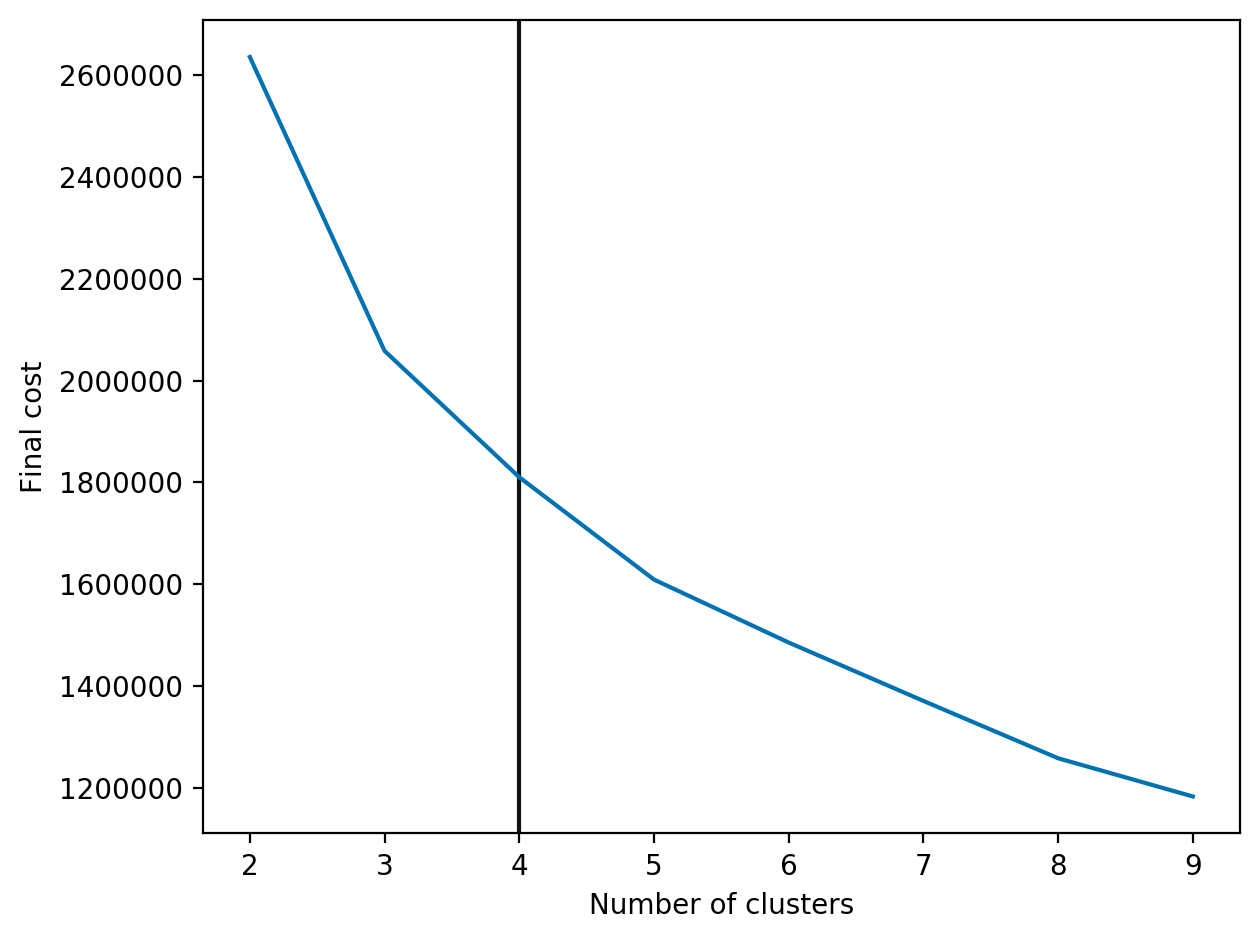

In [4]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)

ax.set(
    xlabel="Number of clusters",
    ylabel="Final cost",
    ylim=ylims,
)

plt.tight_layout()
plt.savefig("../img/knee_results.pdf", transparent=True)

In [5]:
copd = pd.read_csv("../data/clusters/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])
copd = copd.dropna(subset=["cluster"])
copd["cluster"] = copd["cluster"].astype(int)

In [6]:
copd["cluster"].value_counts().sort_index()

0    1084
1    2096
2    7540
3     157
Name: cluster, dtype: int64

In [7]:
kde_ylims = (-0.01, 0.18)

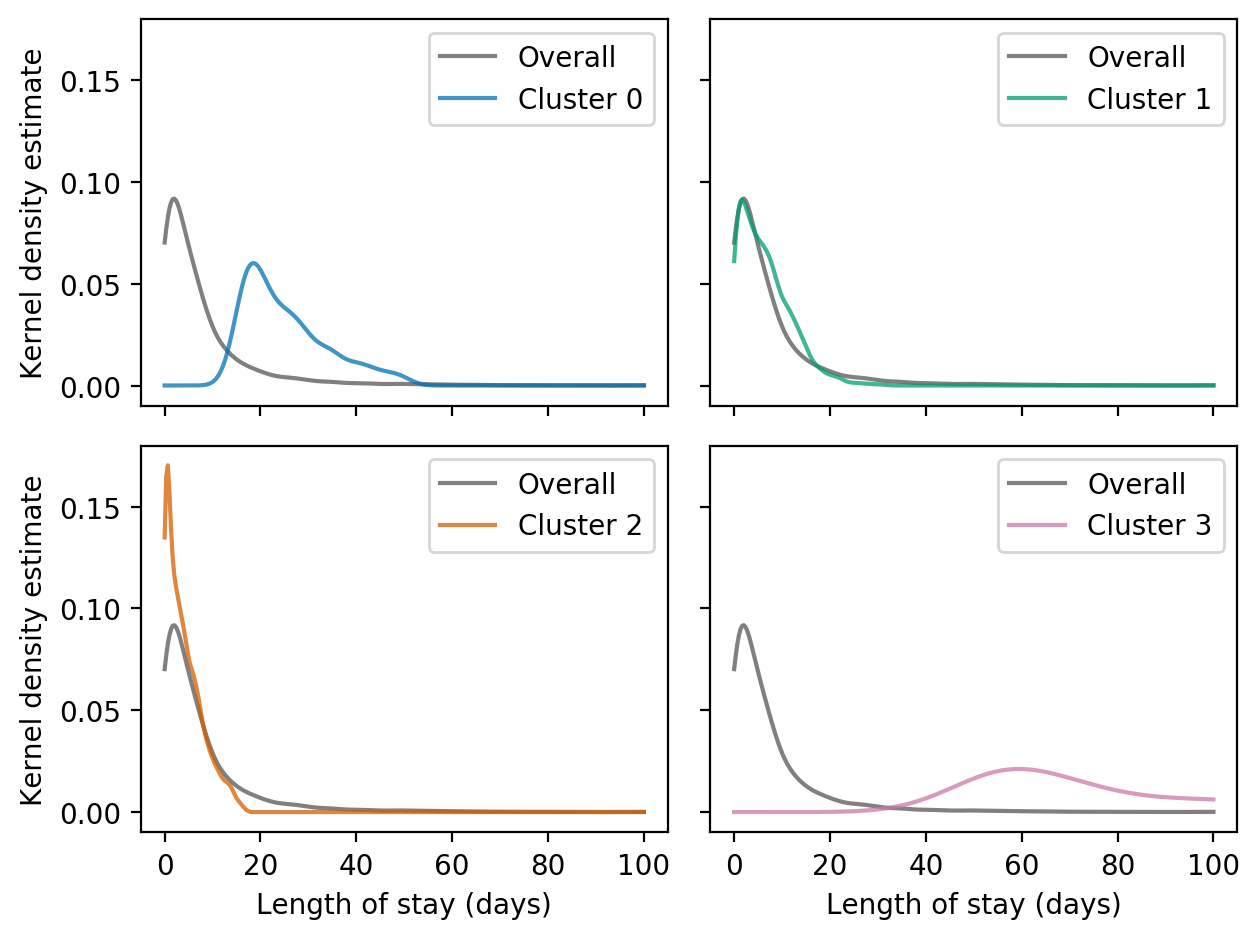

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

xs = np.linspace(0, 100, 300)

for pos, (ax, cluster) in enumerate(zip(axes, range(n_clusters))):

    kernel = stats.gaussian_kde(copd["true_los"])
    ax.plot(xs, kernel(xs), "gray", label="Overall")

    times = copd[copd["cluster"] == cluster]["true_los"]
    kernel = stats.gaussian_kde(times)

    ax.plot(
        xs,
        kernel(xs),
        color=colours[cluster],
        alpha=0.75,
        label=f"Cluster {cluster}",
    )

    ax.set_ylim(kde_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Kernel density estimate")

    ax.legend()
    plt.tight_layout()

plt.tight_layout()
plt.savefig("../img/cluster_los.pdf", transparent=True)

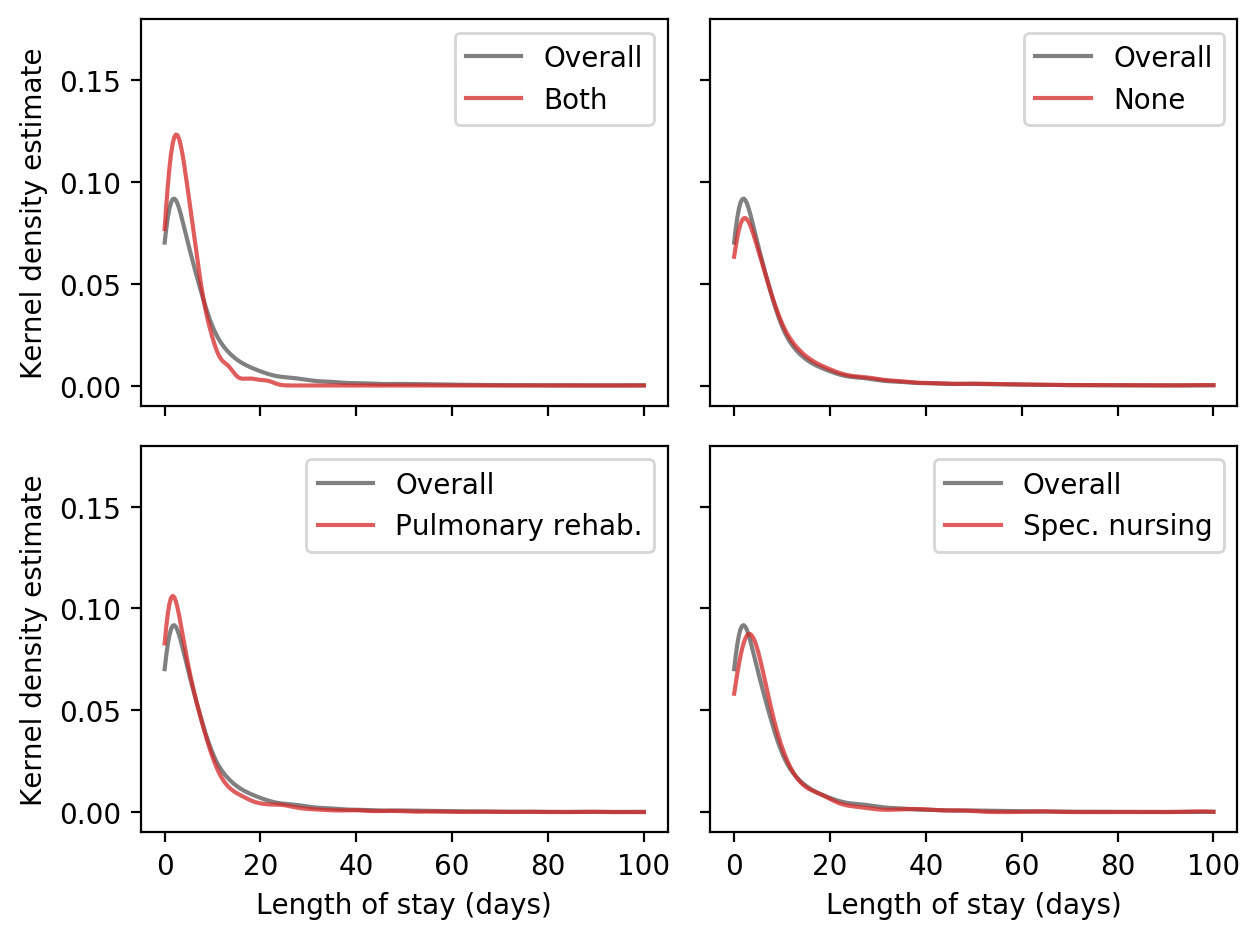

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

intervention_labels = {"none": "None", "both": "Both", "pr": "Pulmonary rehab.", "sn": "Spec. nursing"}

xs = np.linspace(0, 100, 300)

for pos, (ax, intervention) in enumerate(zip(axes, ["both", "none", "pr", "sn"])):

    kernel = stats.gaussian_kde(copd["true_los"])
    ax.plot(xs, kernel(xs), "gray", label="Overall")

    times = copd[copd["intervention"] == intervention]["true_los"]
    kernel = stats.gaussian_kde(times)

    ax.plot(
        xs,
        kernel(xs),
        color="tab:red",
        alpha=0.75,
        label=intervention_labels[intervention],
    )

    ax.set_ylim(kde_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Kernel density estimate")

    ax.legend()
    plt.tight_layout()

plt.tight_layout()
plt.savefig("../img/intervention_los.pdf", transparent=True)

In [10]:
def histograms(data, column, group="cluster", density=True, colours=colours, bins=10):

    fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
    axes = axes.reshape(4)

    column_labels = {
        "wimd": "Welsh Index of Multiple Deprivation",
        "charlson_gross": "Charlson Comorbidity Index",
        "n_copd_admissions_last_year": "COPD admissions in last year",
        "n_icds": "No. of ICDs",
        "age": "Age (years)",
        "spell_cost": "Cost of spell (£1000s)",
        "n_episodes": "No. of episodes",
    }
    
    str_ints = (x for x in range(10))
    for (label, values), ax in zip(copd.groupby(group)[column], axes):

        factor = 1000 if column == "spell_cost" else 1
        ax.hist(
            copd[column] / factor,
            bins=bins,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="Overall",
        )

        label_name = intervention_labels.get(label, f"Cluster {label}")
        if isinstance(label, str):
            label = next(str_ints)
            colour = "tab:red"
        else:
            colour = colours[label]

        ax.hist(
            values / factor, bins=bins, alpha=0.5, facecolor=colour, density=True, label=label_name
        )

        if label > 1:
            ax.set_xlabel(column_labels[column])
        if label % 2 == 0:
            ax.set_ylabel("Frequency density")

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../img/{group}_{column}.pdf", transparent=True)

/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in l

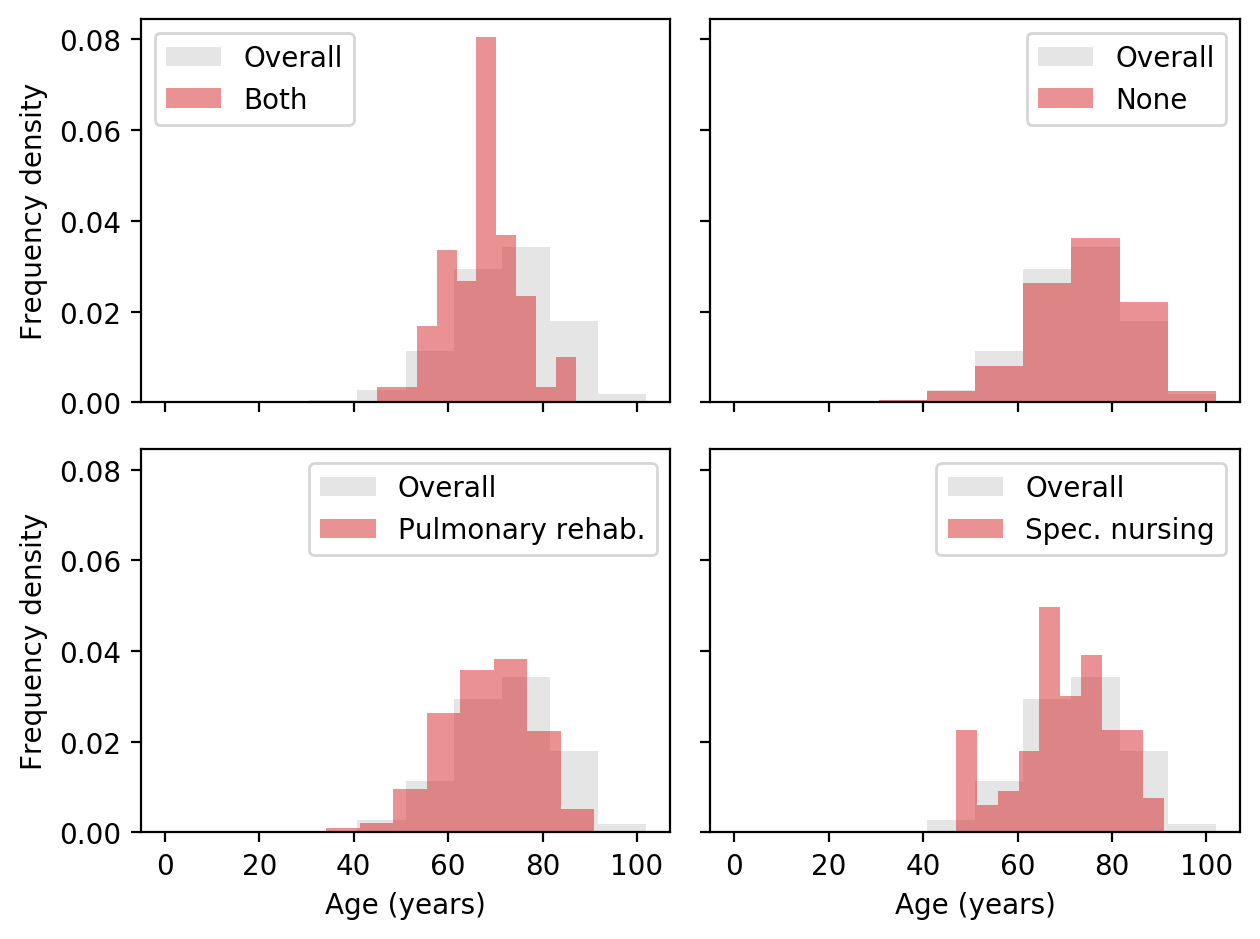

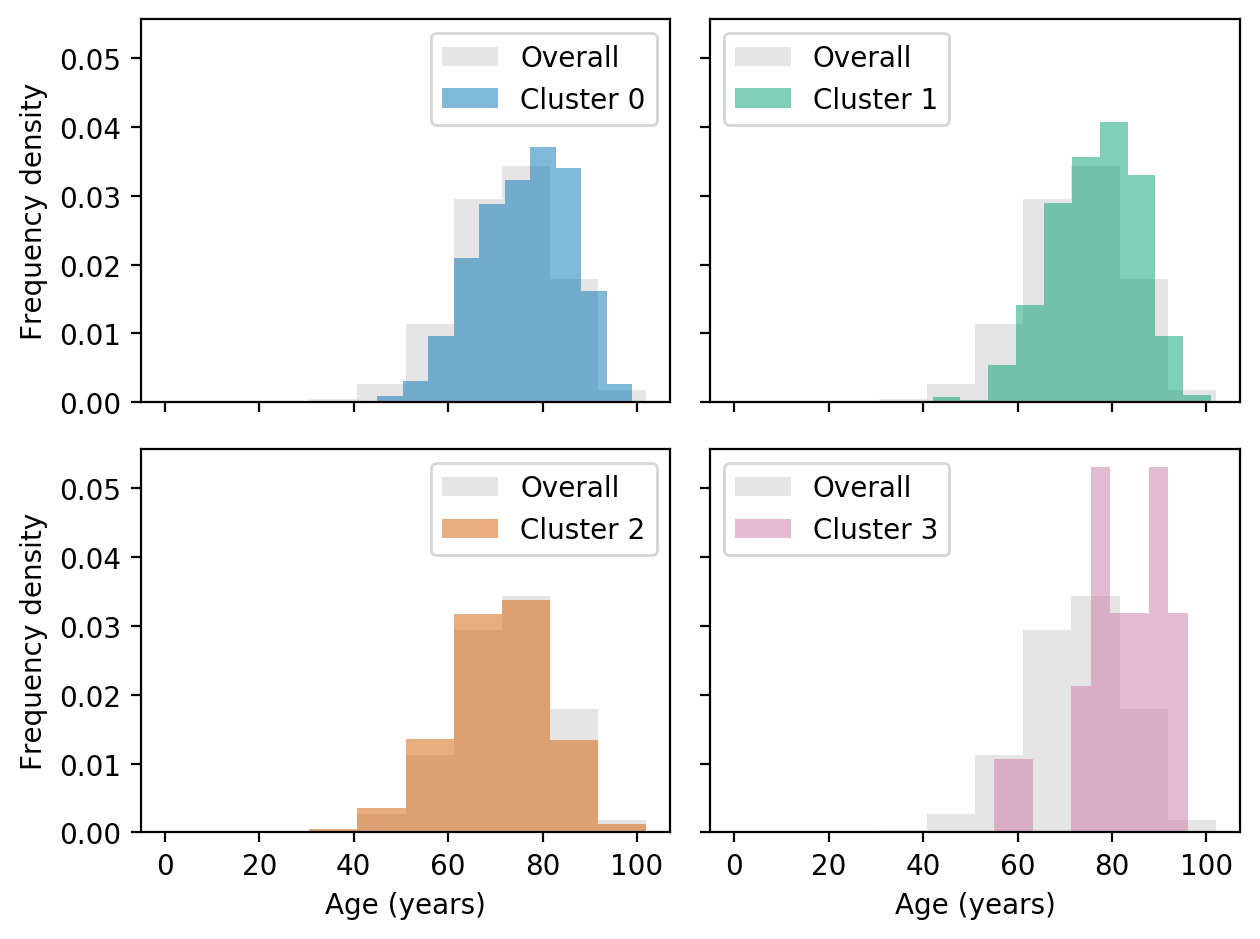

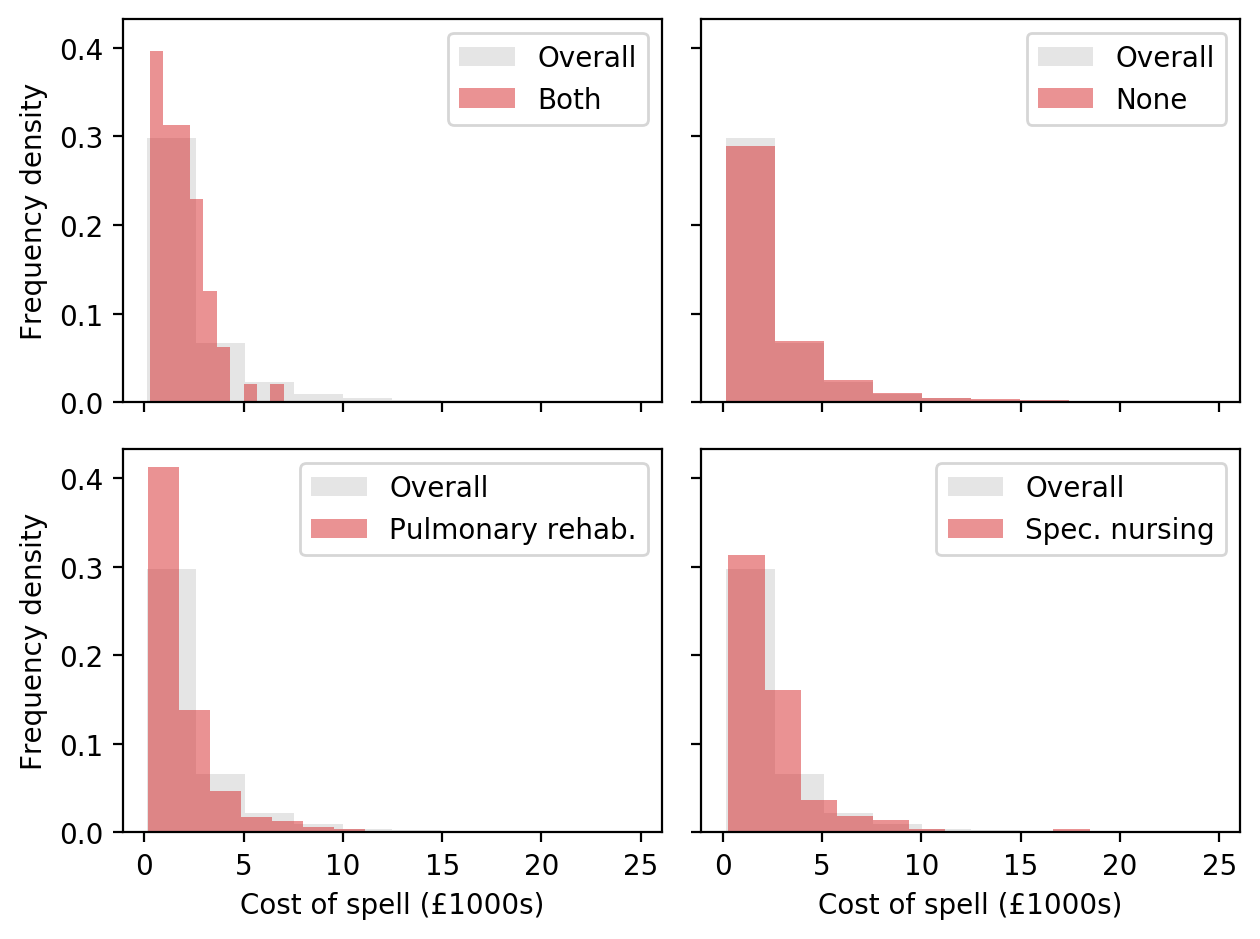

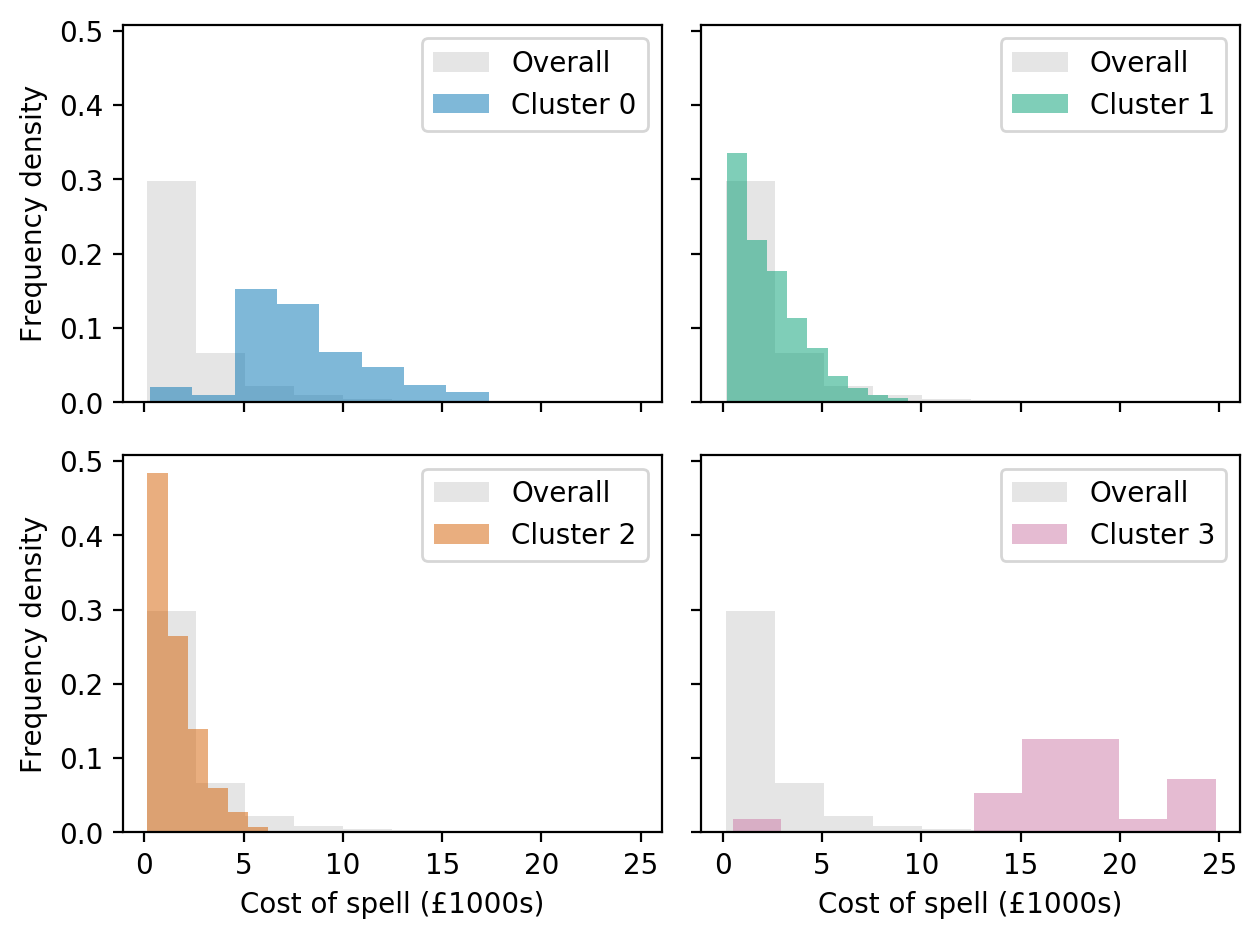

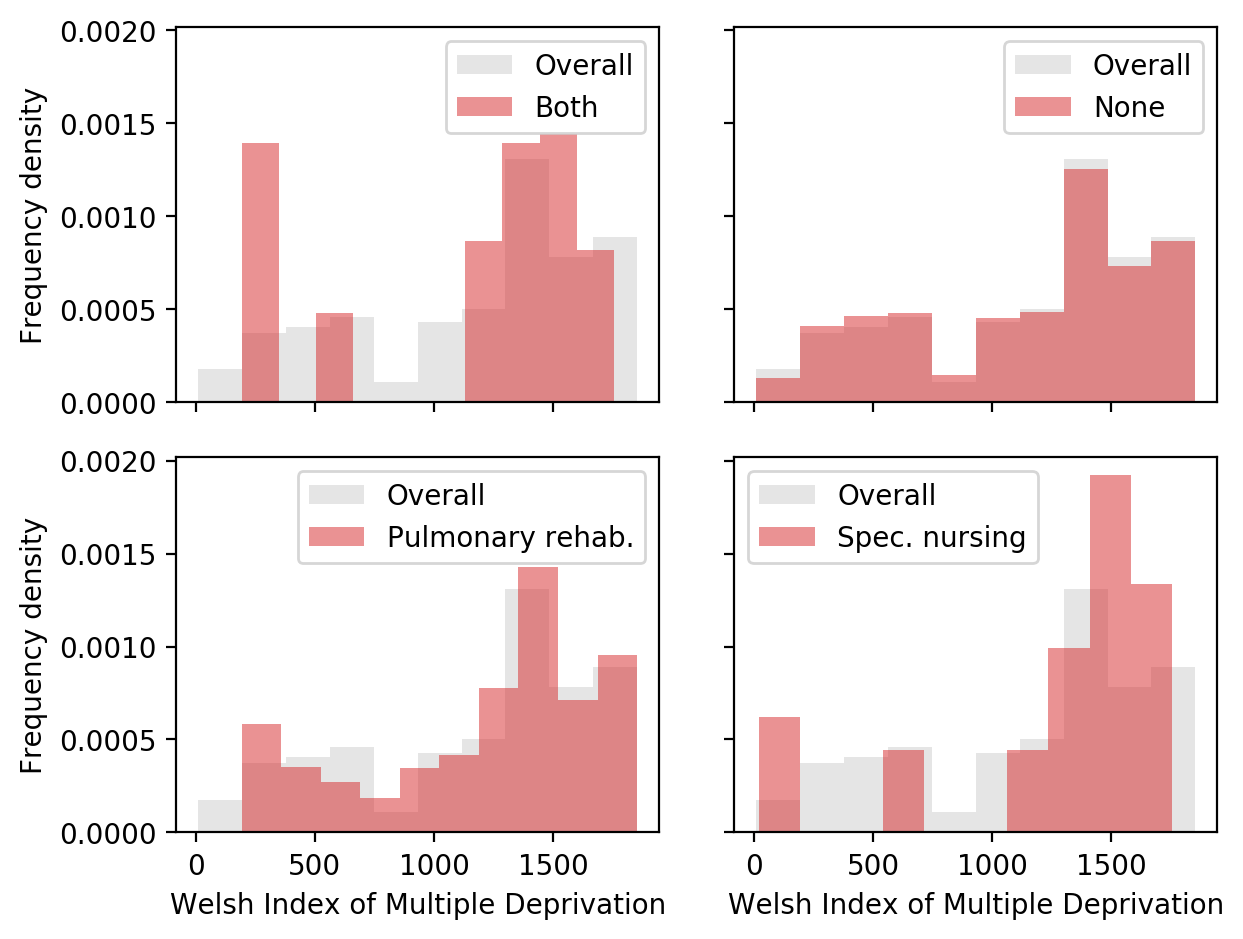

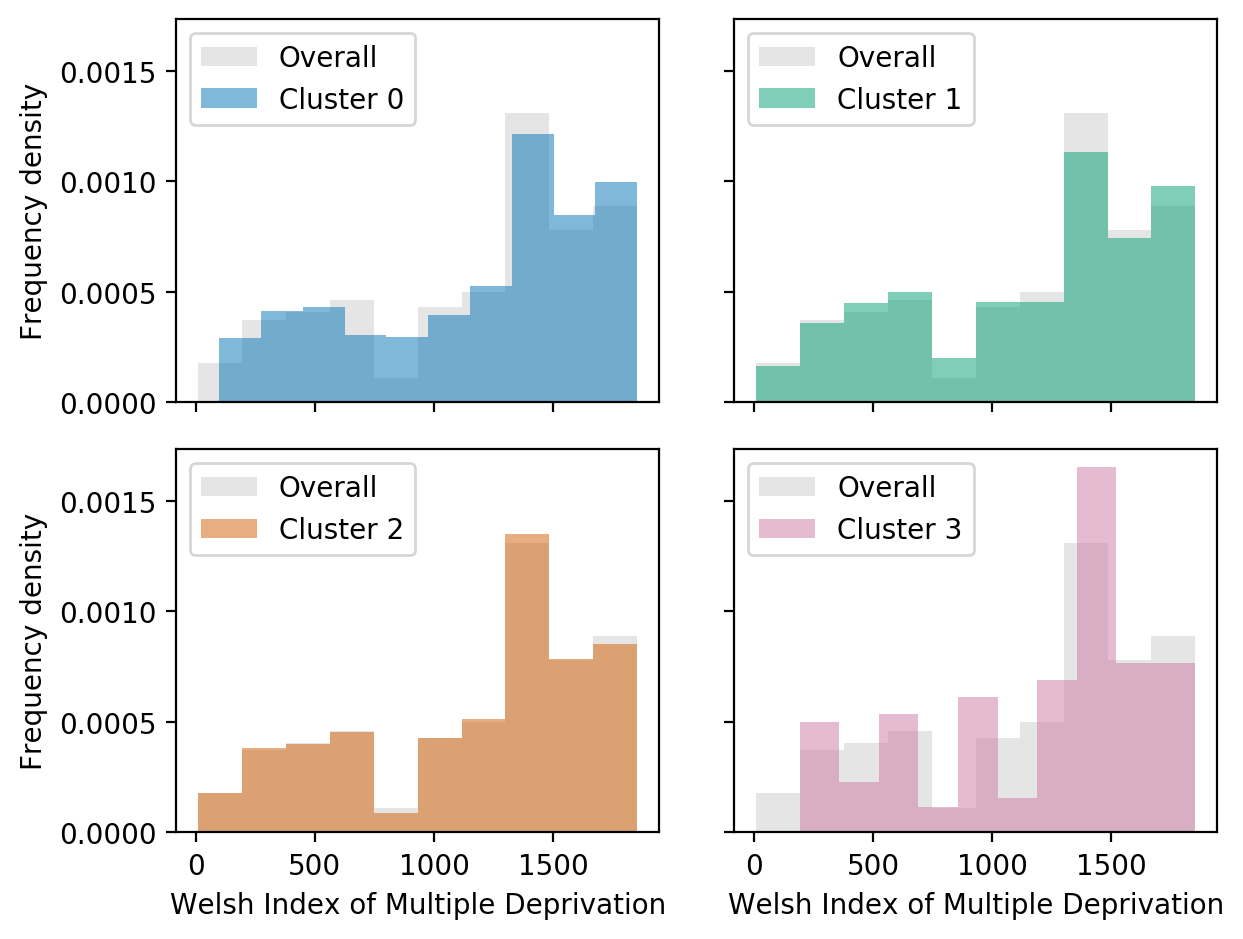

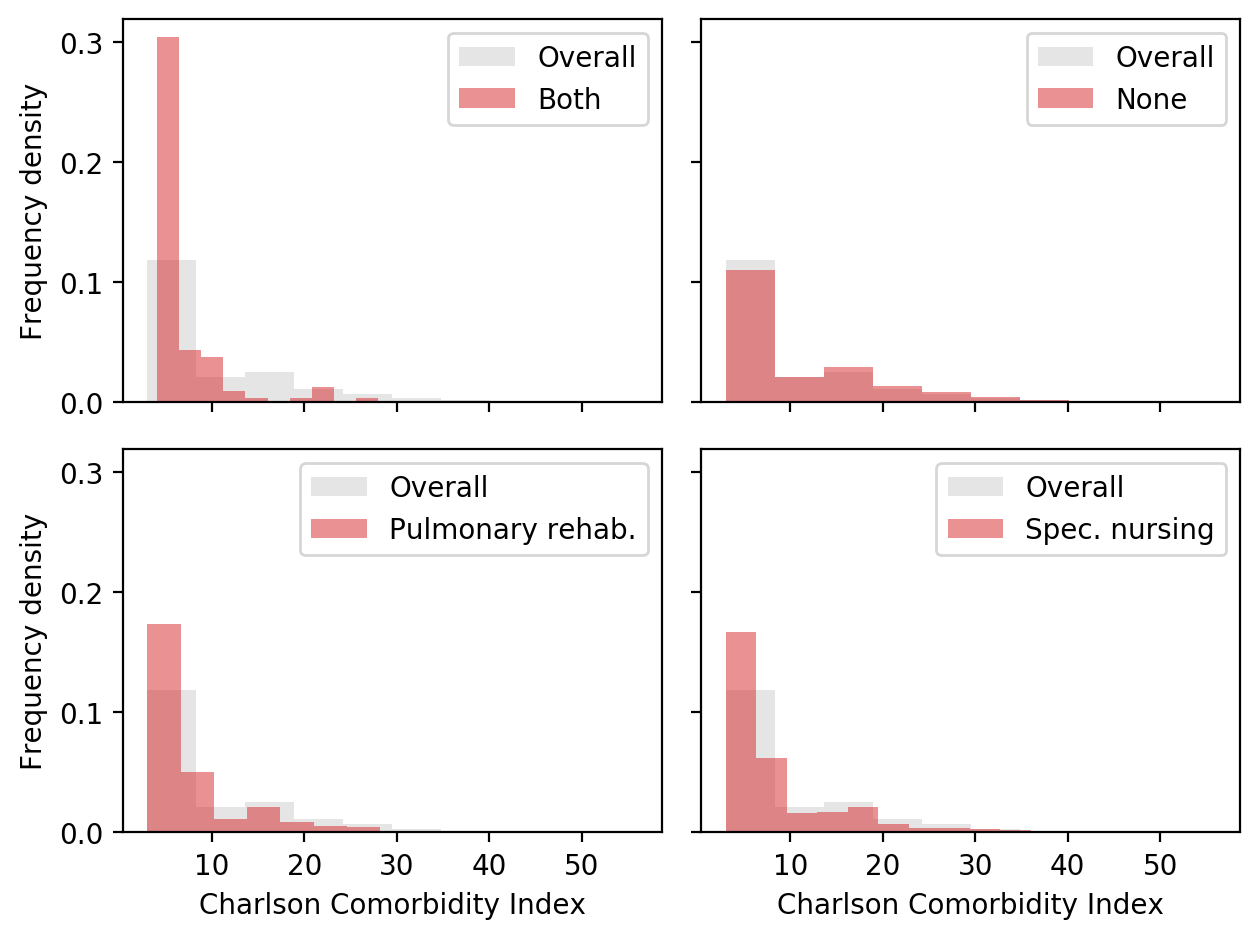

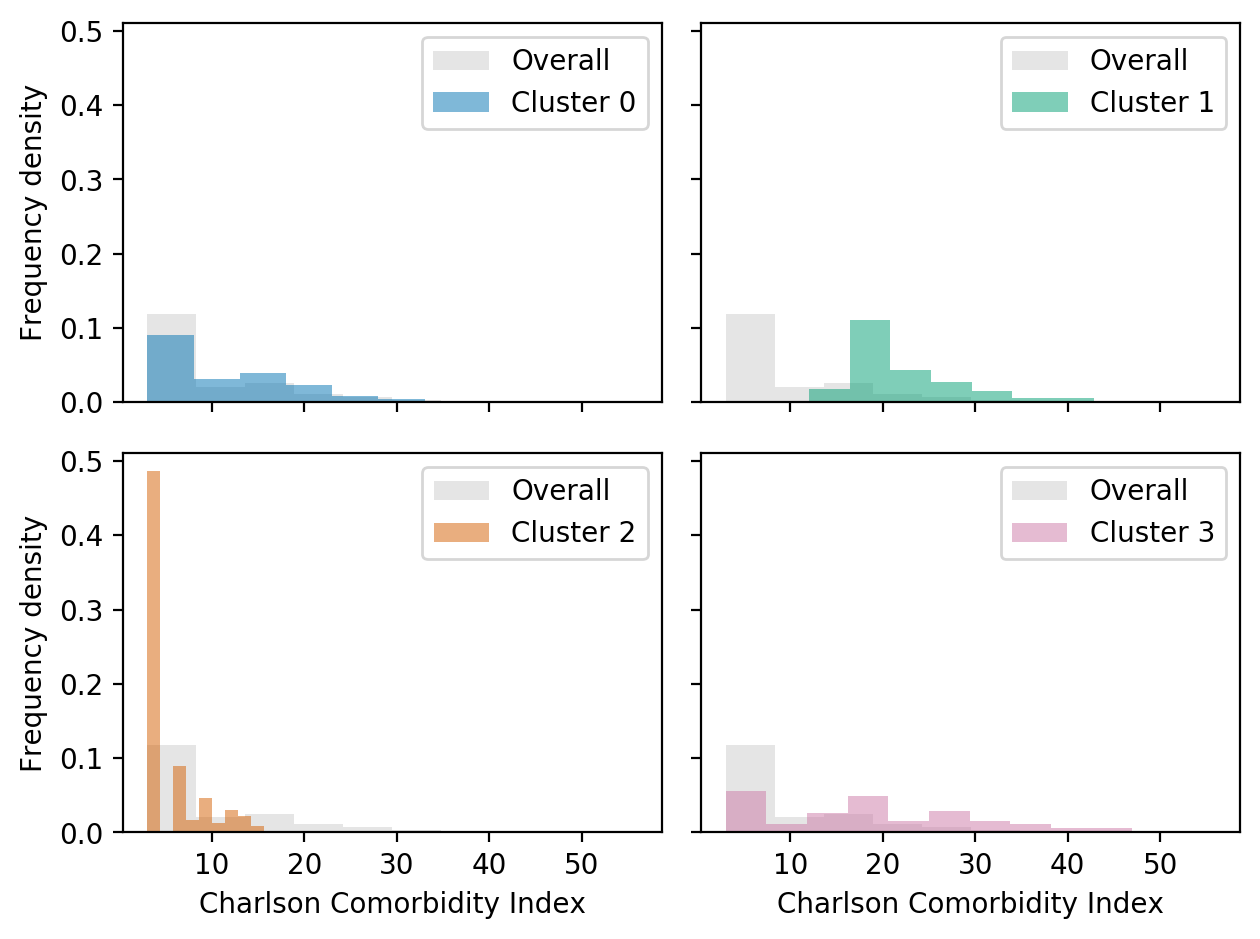

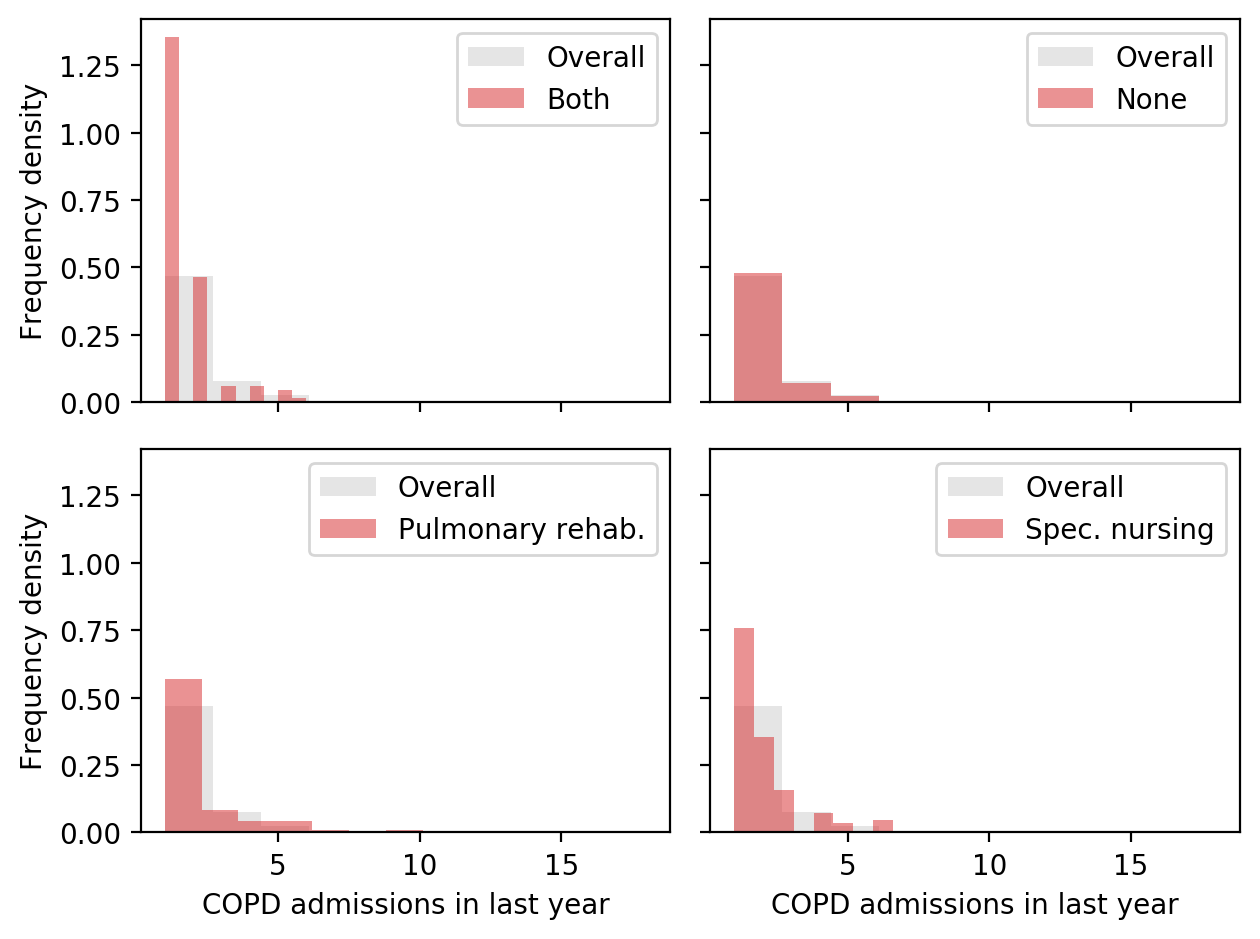

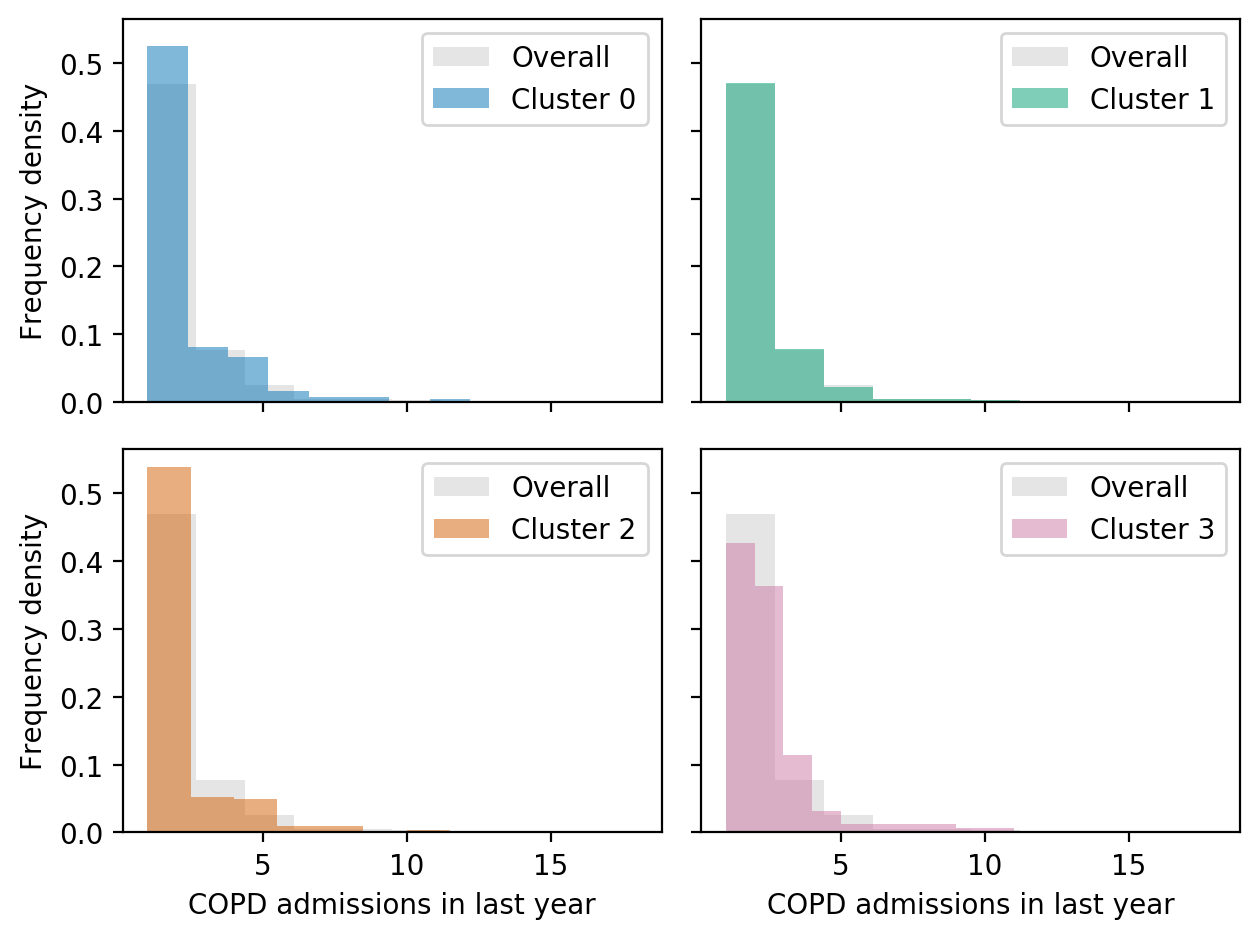

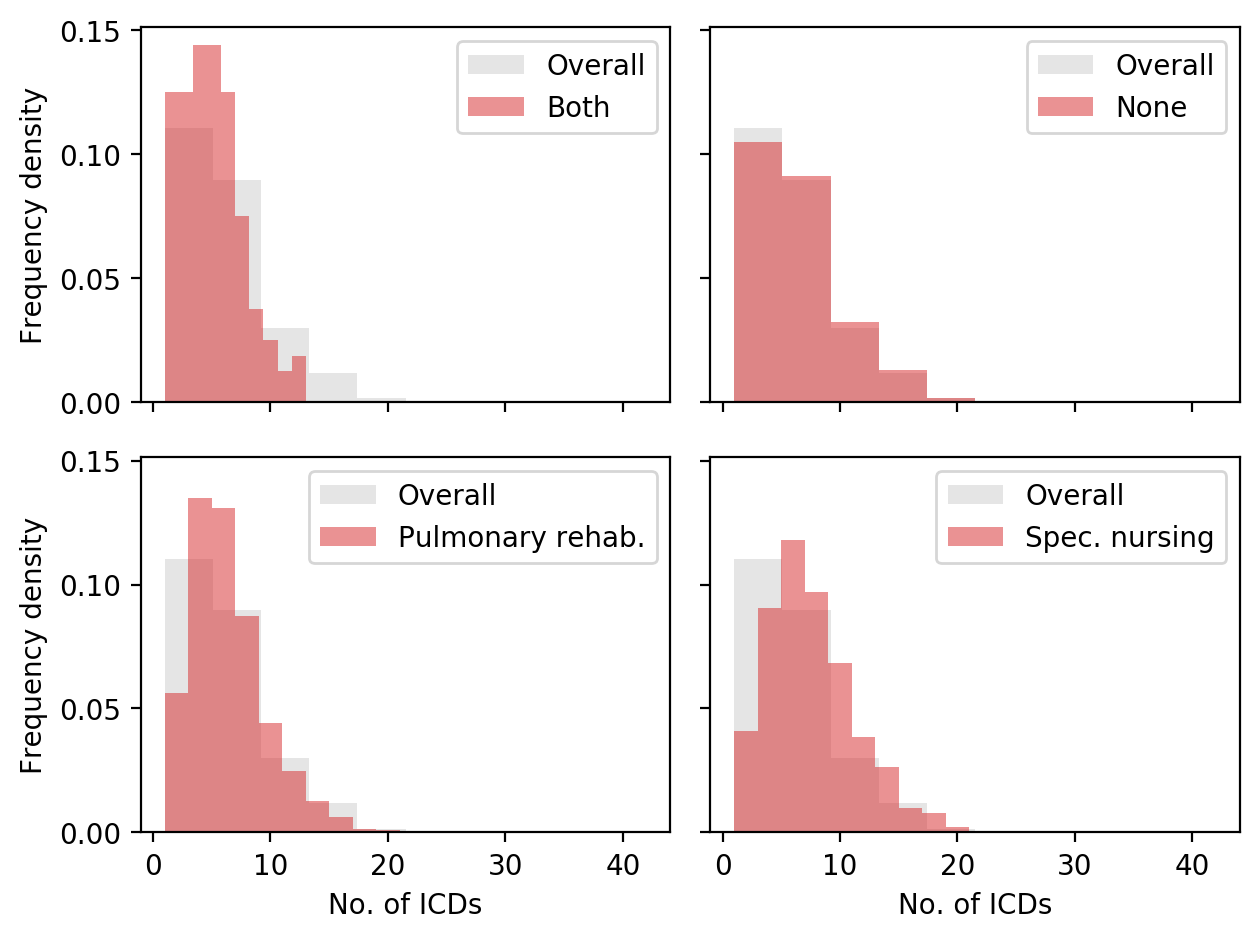

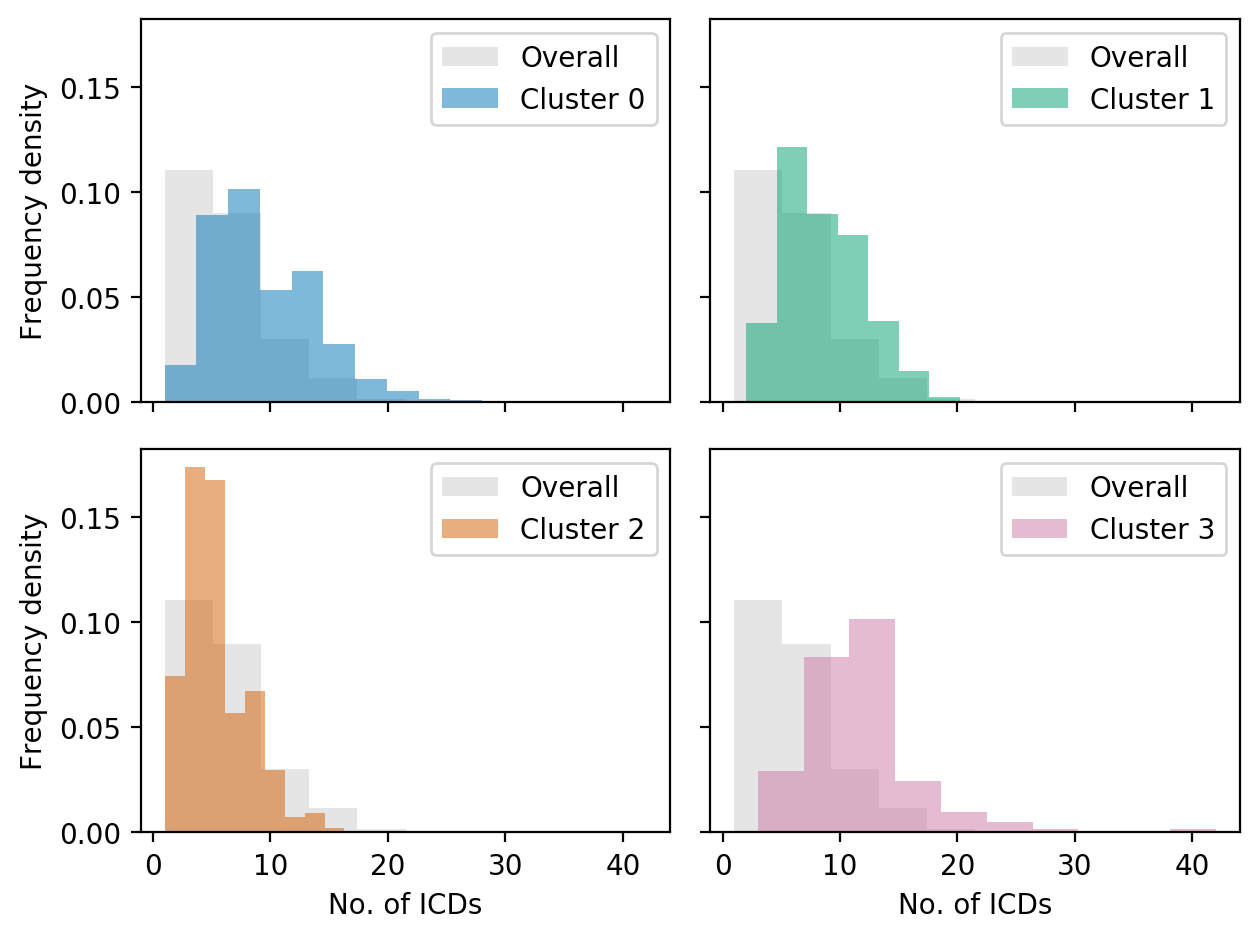

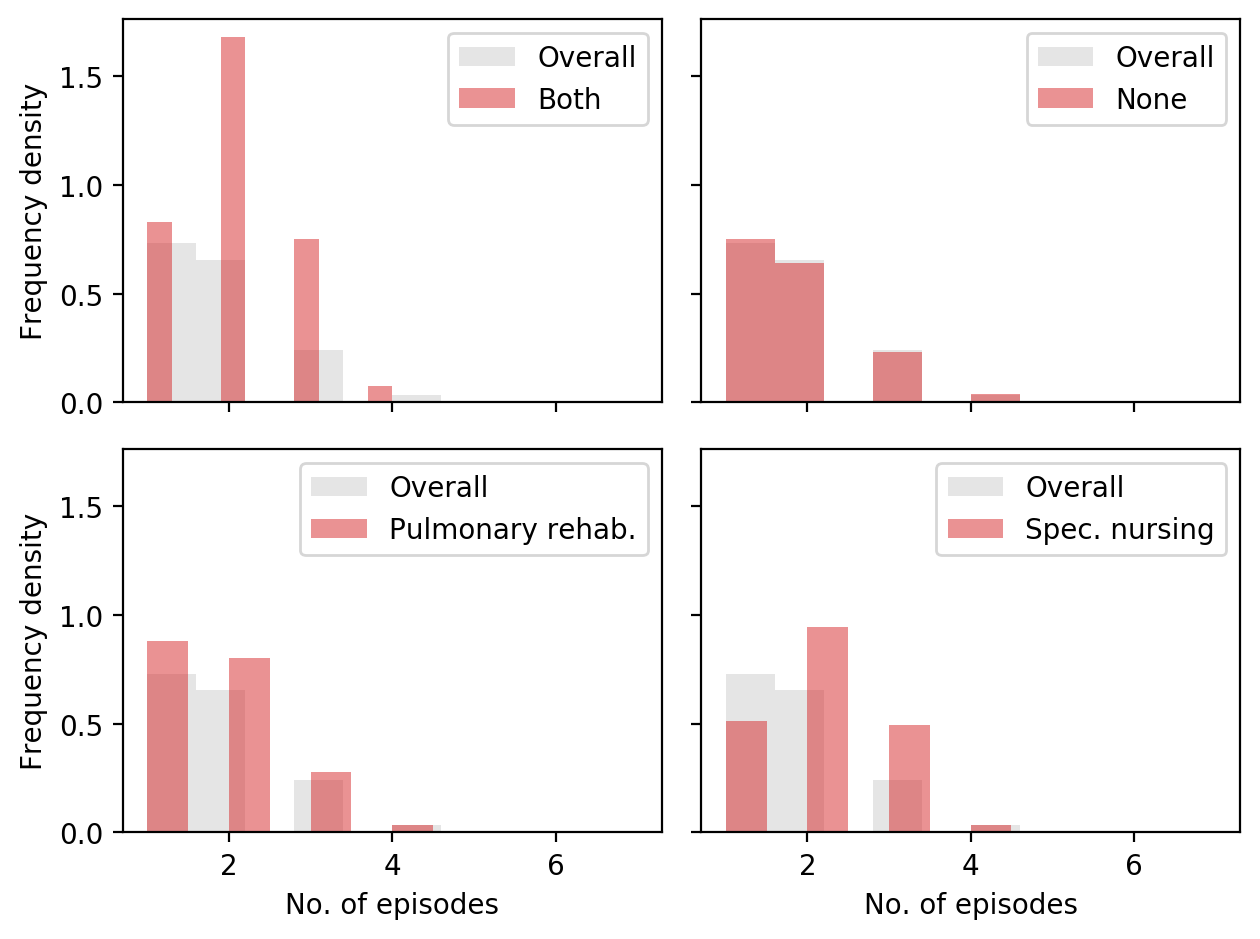

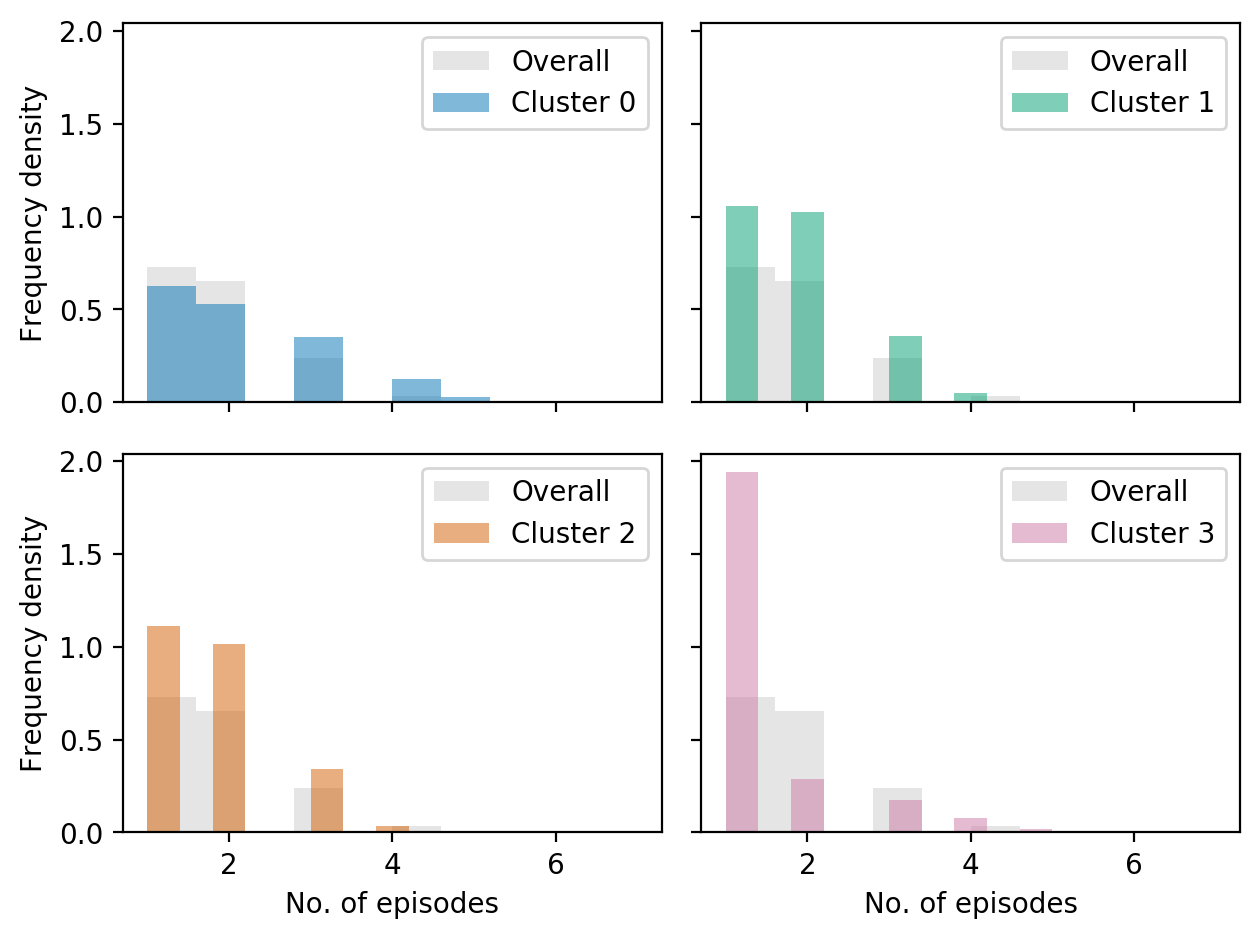

In [11]:
for col in [
    "age",
    "spell_cost",
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
    "n_episodes",
]:
    histograms(copd, col, group="intervention")
    histograms(copd, col, group="cluster")

In [12]:
dfs = []
for cluster, values in copd.groupby(
    ["cluster", "patient_id"]
)[conditions].max().astype(bool).sum(axis=1).reset_index().groupby("cluster")[0]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(pd.DataFrame(data=proportions.values, index=proportions.index, columns=[cluster]))

for intervention, values in copd.groupby(
    ["intervention", "patient_id"]
)[conditions].max().astype(bool).sum(axis=1).reset_index().groupby("intervention")[0]:
    proportions = values.value_counts(normalize=True).sort_index()
    dfs.append(pd.DataFrame(data=proportions.values, index=proportions.index, columns=[intervention]))

ltcs_proportions = pd.concat(dfs, axis=1).fillna(0)

values = copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1)
proportions = values.value_counts(normalize=True)

ltcs_proportions["Population"] = proportions
ltcs_proportions

,0,1,2,3,both,none,pr,sn,Population
1,0.327059,0.000000,0.608367,0.172185,0.729730,0.399706,0.528785,0.447674,0.426496
2,0.385882,0.305768,0.319052,0.298013,0.175676,0.299413,0.295309,0.337209,0.298796
3,0.212941,0.400278,0.067540,0.264901,0.067568,0.185665,0.105544,0.104651,0.167463
4,0.060000,0.211953,0.005040,0.198675,0.013514,0.082681,0.047974,0.087209,0.076850
5,0.012941,0.059764,0.000000,0.052980,0.013514,0.023483,0.013859,0.011628,0.021411
6,0.001176,0.016678,0.000000,0.013245,0.000000,0.007583,0.006397,0.011628,0.007456
7,0.000000,0.005559,0.000000,0.000000,0.000000,0.001223,0.002132,0.000000,0.001338
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,0.000191


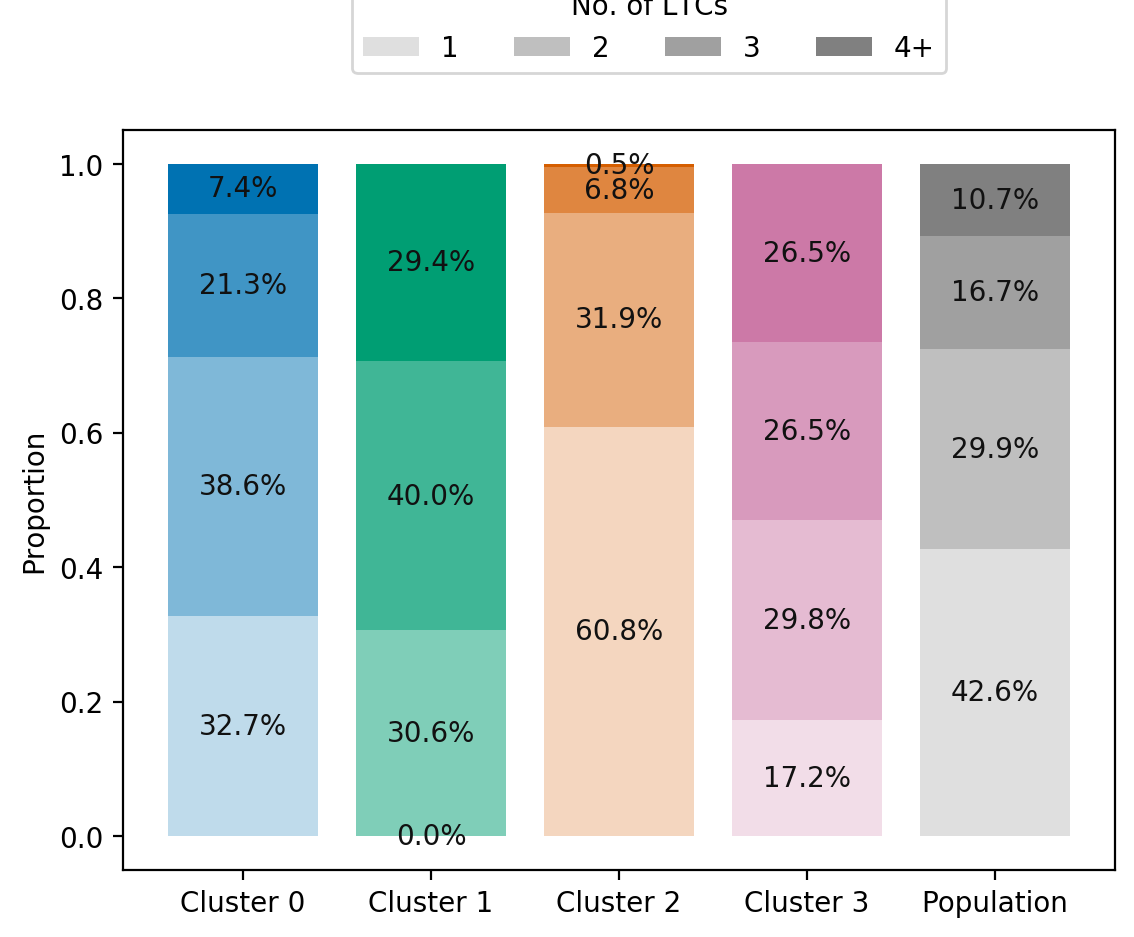

In [13]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in [0, 1, 2, 3, "Population"]:

    bottom = 0
    pos = column
    if isinstance(column, str):
        colour = "gray"
    else:
        colour = colours[column]
        pos = f"Cluster {column}"

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(pos, bottom + .5 * value, f"{value * 100:.1f}%", color="k", va="center", ha="center")
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.75, 1.01), title="No. of LTCs")

plt.savefig("../img/cluster_ltcs.pdf", bbox_extra_artists=[leg], transparent=True)

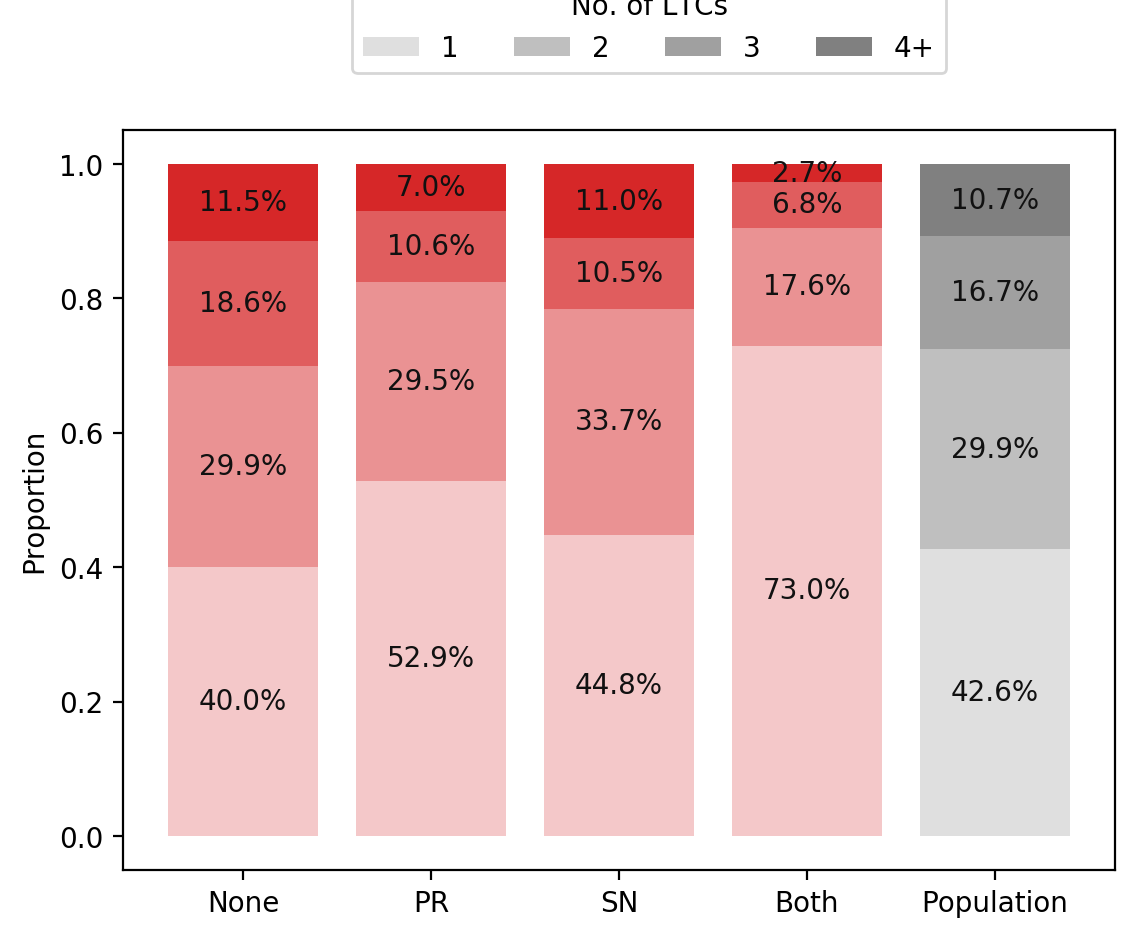

In [14]:
fig, ax = plt.subplots(dpi=200)

handles, labels = [], []
for column in ["none", "pr", "sn", "both", "Population"]:

    bottom = 0
    pos = column
    if column == "Population":
        colour = "gray"
    else:
        colour = "tab:red"
        pos = intervention_labels[column]
        if column in ["pr", "sn"]:
            pos = column.upper()

    for i in range(1, 5):

        alpha = i / 4
        value = ltcs_proportions.loc[i, column]
        if i == 4:
            value = ltcs_proportions.loc[i:, column].sum()
            i = "4+"

        ax.bar(pos, value, bottom=bottom, fc=colour, alpha=alpha)
        ax.text(pos, bottom + .5 * value, f"{value * 100:.1f}%", color="k", va="center", ha="center")
        bottom += value

        if str(i) not in labels:
            labels.append(str(i))
            handles.append(plt.matplotlib.patches.Patch(fc="gray", alpha=alpha))

ax.set(ylabel="Proportion", ylim=(-0.05, 1.05))

leg = fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.75, 1.01), title="No. of LTCs")

plt.savefig("../img/intervention_ltcs.pdf", bbox_extra_artists=[leg], transparent=True)

In [15]:
cluster_attendances = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_attendances[label] = [cluster.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]

cluster_mean_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_mean_lengths[label] = [cluster.groupby("patient_id")["true_los"].mean().mean()]

cluster_min_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].min().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_min_lengths[label] = [cluster.groupby("patient_id")["true_los"].min().min()]

cluster_max_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].max().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_max_lengths[label] = [cluster.groupby("patient_id")["true_los"].max().max()]

cluster_nicds = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_icds"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_nicds[label] = [cluster.groupby("patient_id")["n_icds"].median().median()]
    
cluster_ltcs = pd.DataFrame({"Population": [copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ltcs[label] = [cluster.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).median()]

cluster_charlsons = pd.DataFrame({"Population": [copd.groupby("patient_id")["charlson_gross"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_charlsons[label] = [cluster.groupby("patient_id")["charlson_gross"].median().median()]

cluster_costs = pd.DataFrame({"Population": [copd["spell_cost"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_costs[label] = [cluster["spell_cost"].mean()]

cluster_ages = pd.DataFrame({"Population": [copd["age"].mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ages[label] = [cluster.groupby("patient_id")["age"].max().mean()]

In [16]:
cluster_characteristics = [
    cluster_costs,
    cluster_ages,
    cluster_attendances,
    cluster_min_lengths,
    cluster_mean_lengths,
    cluster_max_lengths,
    cluster_ltcs,
    cluster_nicds,
    cluster_charlsons,
]

overall_characteristic = pd.concat(cluster_characteristics, ignore_index=True)
overall_characteristic.index = [
    "Mean spell cost",
    "Mean age",
    "Mean COPD adm. in year",
    "Min. LOS",
    "Mean LOS",
    "Max. LOS",
    "Median no. of LTCs",
    "Median no. ICDs",
    "Median CCI",
]

overall_characteristic = overall_characteristic[[0, 1, 2, 3, "Population"]]

In [17]:
overall_characteristic

,0,1,2,3,Population
Mean spell cost,8083.693807,2312.388094,1509.224444,17847.796449,2280.539439
Mean age,76.150794,77.158470,71.006840,81.363636,72.217018
Mean COPD adm. in year,1.912424,1.506656,1.305084,1.982340,1.289233
Min. LOS,12.822917,-0.004861,-0.020833,48.817361,5.408879
Mean LOS,25.304893,6.446681,3.793179,74.653468,7.474234
Max. LOS,51.360417,30.859028,16.940972,224.927778,10.398216
Median no. of LTCs,2.000000,3.000000,1.000000,3.000000,1.996559
Median no. ICDs,9.000000,8.000000,5.000000,11.000000,6.583158
Median CCI,9.000000,20.000000,4.000000,18.000000,9.720512


In [18]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = data.groupby("patient_id")[conditions].max().astype(bool)


In [19]:
cluster_intervention_proportions = pd.DataFrame({"Population": copd["intervention"].value_counts(normalize=True)})
for cluster, values in copd.groupby("cluster")["intervention"]:
    proportions = values.value_counts(normalize=True).reindex(["none", "pr", "sn", "both"]).fillna(0)
    cluster_intervention_proportions[cluster] = proportions

cluster_intervention_proportions *= 100
new_index = [intervention_labels.get(i) + ", %" for i in cluster_intervention_proportions.index]
cluster_intervention_proportions.index = new_index

In [20]:
overall_condition = pd.DataFrame()
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean() * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean() * 100
overall_condition = overall_condition.sort_values("Population", ascending=False)

condition_labels = {
    "ami": "AMI",
    "cva": "CVA",
    "chf": "CHF",
    "ctd": "CTD",
    "dementia": "Dementia",
    "diabetes": "Diabetes",
    "liver_disease": "Liver disease",
    "peptic_ulcer": "Peptic ulcer",
    "pvd": "PVD",
    "pulmonary_disease": "Pulmonary disease",
    "cancer": "Cancer",
    "diabetic_complications": "Diabetic compl.",
    "paraplegia": "Paraplegia",
    "renal_disease": "Renal disease",
    "metastatic_cancer": "Metastatic cancer",
    "sever_liver_disease": "Severe liver disease",
    "hiv": "HIV",
    "cdiff": "C. diff",
    "mrsa": "MRSA",
    "obese": "Obesity",
    "sepsis": "Sepsis"
}

overall_condition.index = [condition_labels[i] + ", %" for i in overall_condition.index]

In [21]:
summary = pd.concat(
    [overall_characteristic, cluster_intervention_proportions, overall_condition], sort=False
).round(2)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("Intervention prevalence", i) for i in cluster_intervention_proportions.index),
        *(("LTC prevalence", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population (mean)", "")]
)

summary.index = index
summary.columns = columns

summary.to_latex("../tex/summary.tex", multicolumn=False, bold_rows=True)

summary

Cluster                    \
                                                       0        1        2   
Characteristics         Mean spell cost          8083.69  2312.39  1509.22   
                        Mean age                   76.15    77.16    71.01   
                        Mean COPD adm. in year      1.91     1.51     1.31   
                        Min. LOS                   12.82    -0.00    -0.02   
                        Mean LOS                   25.30     6.45     3.79   
                        Max. LOS                   51.36    30.86    16.94   
                        Median no. of LTCs          2.00     3.00     1.00   
                        Median no. ICDs             9.00     8.00     5.00   
                        Median CCI                  9.00    20.00     4.00   
Intervention prevalence None, %                    80.26    83.40    65.76   
                        Pulmonary rehab., %        15.77    13.41    27.96   
                        Spec. nursing, %            3.78     2.91     4.63   
                        Both, %                     0.18     0.29     1.66   
LTC prevalence          Pulmonary disease, %      100.00   100.00   100.00   
                        Diabetes, %                20.12    28.70    16.71   
                        CHF, %                     14.47    54.62     0.00   
                        AMI, %                     14.35    23.42    10.86   
                        Renal disease, %            8.59    22.52     3.02   
                        Cancer, %                   8.12    13.69     4.11   
                        Dementia, %                 7.53    20.08     0.00   
                        CVA, %                      9.65    15.01     1.21   
                        PVD, %                      5.06     8.90     3.18   
                        CTD, %                      5.18     5.07     4.01   
                        Obesity, %                  2.82     3.75     2.22   
                        Metastatic cancer, %        1.88     5.70     0.00   
                        Paraplegia, %               1.29     3.96     0.25   
                        Sepsis, %                   2.12     1.25     0.25   
                        Peptic ulcer, %             1.76     1.04     0.35   
                        Diabetic compl., %          0.24     0.69     0.33   
                        Liver disease, %            0.35     0.56     0.33   
                        Severe liver disease, %     0.24     0.63     0.00   
                        C. diff, %                  0.82     0.14     0.03   
                        MRSA, %                     0.35     0.07     0.05   
                        HIV, %                      0.00     0.00     0.03   

                                                          Population (mean)  
                                                        3                    
Characteristics         Mean spell cost          17847.80           2280.54  
                        Mean age                    81.36             72.22  
                        Mean COPD adm. in year       1.98              1.29  
                        Min. LOS                    48.82              5.41  
                        Mean LOS                    74.65              7.47  
                        Max. LOS                   224.93             10.40  
                        Median no. of LTCs           3.00              2.00  
                        Median no. ICDs             11.00              6.58  
                        Median CCI                  18.00              9.72  
Intervention prevalence None, %                     89.81             70.95  
                        Pulmonary rehab., %          8.92             23.66  
                        Spec. nursing, %             1.27              4.16  
                        Both, %                      0.00              1.22  
LTC prevalence          Pulmonary disease, %       100.00            1